In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

#### Downloading the data

In [161]:
data = pd.read_csv(r"D:\01.Educación\03.MMA\04.Winter 1 2025\04. Adv Topics in IS 1 (INSY-695)\05.Assignments\Assignment 1\data\walmart.csv",parse_dates=['transaction_date'])
data.head()


,transaction_id,customer_id,product_id,product_name,category,quantity_sold,unit_price,transaction_date,store_id,store_location,inventory_level,reorder_point,reorder_quantity,supplier_id,supplier_lead_time,customer_age,customer_gender,customer_income,customer_loyalty_level,payment_method,promotion_applied,promotion_type,weather_conditions,holiday_indicator,weekday,stockout_indicator,forecasted_demand,actual_demand
0,1,2824,843,Fridge,Electronics,3,188.46,2024-03-31 21:46:00,3,"Miami, FL",246,116,170,474,8,29,Other,98760.83,Silver,Credit Card,True,NaN,Stormy,False,Friday,True,172,179
1,2,1409,135,TV,Electronics,4,1912.04,2024-07-28 12:45:00,5,"Dallas, TX",43,70,212,135,4,34,Other,69781.93,Gold,Cash,True,Percentage Discount,Rainy,False,Monday,True,109,484
2,3,5506,391,Fridge,Electronics,4,1377.75,2024-06-10 04:55:00,1,"Los Angeles, CA",411,94,252,475,2,69,Other,77373.10,Platinum,Cash,False,NaN,Sunny,False,Tuesday,True,289,416
3,4,5012,710,Smartphone,Electronics,5,182.31,2024-08-15 01:03:00,5,"Miami, FL",452,87,112,118,7,47,Other,33383.04,Silver,Cash,True,Percentage Discount,Sunny,True,Sunday,False,174,446
4,5,4657,116,Laptop,Electronics,3,499.28,2024-09-13 00:45:00,6,"Chicago, IL",412,99,177,155,4,70,Female,108999.41,Bronze,Digital Wallet,False,NaN,Sunny,False,Thursday,True,287,469


In [162]:
#The granularity of this data is by transaction each customer transaction
#also we can appreciate that we have a time series data for the demand
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_id          5000 non-null   int64         
 1   customer_id             5000 non-null   int64         
 2   product_id              5000 non-null   int64         
 3   product_name            5000 non-null   object        
 4   category                5000 non-null   object        
 5   quantity_sold           5000 non-null   int64         
 6   unit_price              5000 non-null   float64       
 7   transaction_date        5000 non-null   datetime64[ns]
 8   store_id                5000 non-null   int64         
 9   store_location          5000 non-null   object        
 10  inventory_level         5000 non-null   int64         
 11  reorder_point           5000 non-null   int64         
 12  reorder_quantity        5000 non-null   int64   

In [163]:
# We decide to predict the demand based on a product granulairity
# since we do not have enough categories for a more diverse and insightful
# analysis
data.describe()
data["category"].nunique() #2 categories
data["product_name"].nunique()#8 categories
data["customer_id"].nunique() #2848 categories


3848

#### Data aggregation

In [164]:
# Create month and year column 
data["month"] = pd.to_datetime(data["transaction_date"]).dt.month
data["year"] = pd.to_datetime(data["transaction_date"]).dt.year
data["period"] = data["year"].astype(str) + "-" + data["month"].astype(str)

#Create the different layers of aggregation
level = [
    "period",
    "category",
    "product_name"
]

# Create the new dataframe with different aggregation methods for each column 
df = data.groupby(level).agg(
    {
        "transaction_id": "nunique",
        "quantity_sold": "sum",
        "unit_price": ["mean","std"],
        "store_id": "nunique",
        "store_location": "nunique",
        "inventory_level": "sum",
        'reorder_point': 'mean', #Check later for data leakage
        'reorder_quantity': 'mean', #Check later for data leakage
        'supplier_lead_time': ['mean',"std"],  #Check later for data leakage
        "customer_age": ["mean","std"],
        "customer_income": ["mean","std"],
        "promotion_applied": "sum",
        "holiday_indicator": "sum",
        "stockout_indicator": "sum",
        "actual_demand":"sum",
        'payment_method': lambda x: x.value_counts().index[0] if len(x.value_counts())>0 else None,
        'promotion_type': lambda x: x.value_counts().index[0] if len(x.value_counts())>0 else None,
        'weather_conditions': lambda x: x.value_counts().index[0] if len(x.value_counts())>0 else None,
        'weekday': lambda x: x.value_counts().index[0] if len(x.value_counts())>0 else None,
        'customer_loyalty_level': lambda x: x.value_counts().index[0] if len(x.value_counts())>0 else None,
        'customer_gender': lambda x: x.value_counts().index[0] if len(x.value_counts())>0 else None,
    

    }
).reset_index()


df.columns = [i[0] if i[1] == '' else i[0] + "_" + i[1] for i in df.columns]
df.head(1)

# Export the DataFrame to a CSV file
df.to_csv('aggregated_data.csv', index=False)

print("DataFrame successfully exported to 'aggregated_data.csv'.")

DataFrame successfully exported to 'aggregated_data.csv'.


#### Visualizing data

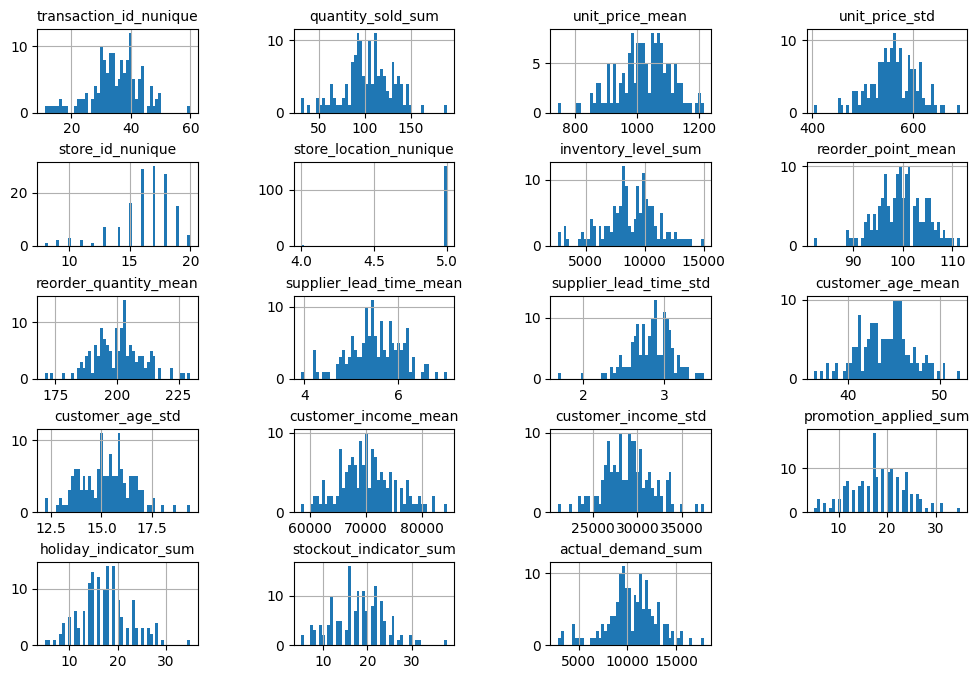

In [165]:
# We predifined some settings for the charts
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
plt.subplots_adjust(wspace=0.6, hspace=0.6)
plt.show()

### Discover and Visualize the Data to Gain Insights

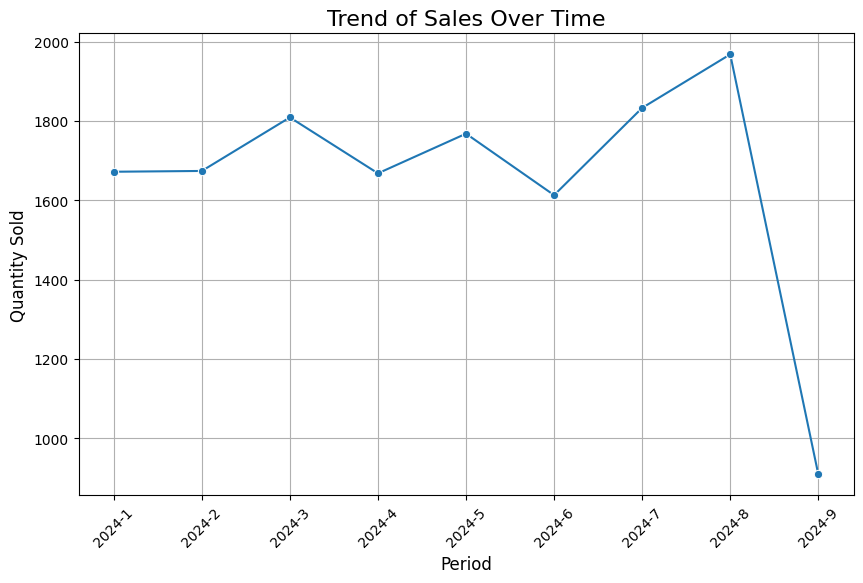

In [166]:
# Group data by period and calculate total sales
sales_trend = df.groupby('period')['quantity_sold_sum'].sum().reset_index()

# Plot sales trend
plt.figure(figsize=(10, 6))
sns.lineplot(data=sales_trend, x='period', y='quantity_sold_sum', marker='o')
plt.title('Trend of Sales Over Time', fontsize=16)
plt.xlabel('Period', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Strong decline in sales analyse for further reasons 

In [167]:
# Check the number of data points for each period
period_counts = df['period'].value_counts().reset_index()
period_counts.columns = ['Period', 'Count']

# Display the counts for each period
print(period_counts)

# Since there is a strong decline in sales in the last period we
# check for any missing data points but it seems consistent with the
# number of data, there might be another reason for the decline 


   Period  Count
0  2024-1     16
1  2024-2     16
2  2024-3     16
3  2024-4     16
4  2024-5     16
5  2024-6     16
6  2024-7     16
7  2024-8     16
8  2024-9     16


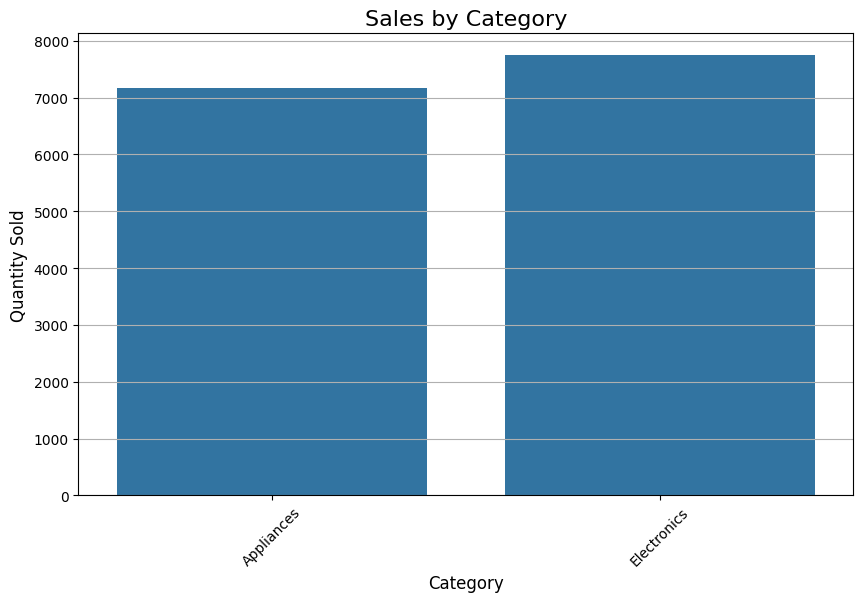

In [168]:
# Group data by category and calculate total sales
category_sales = df.groupby('category')['quantity_sold_sum'].sum().reset_index()

# Plot sales by category
plt.figure(figsize=(10, 6))
sns.barplot(data=category_sales, x='category', y='quantity_sold_sum')
plt.title('Sales by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# We can see that there is balance between our categories so we do not 
# proceed with SMOTE 

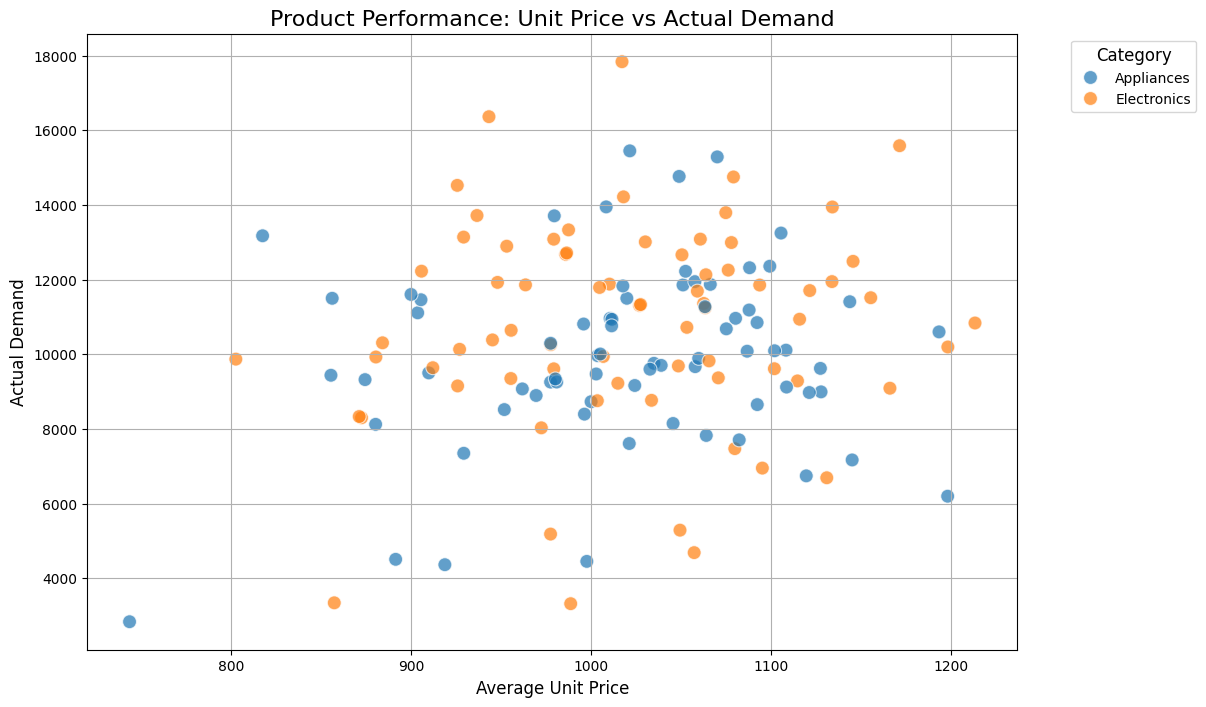

In [169]:
# Scatter plot of unit price mean vs. actual demand sum
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='unit_price_mean', y='actual_demand_sum', hue='category', s=100, alpha=0.7)
plt.title('Product Performance: Unit Price vs Actual Demand', fontsize=16)
plt.xlabel('Average Unit Price', fontsize=12)
plt.ylabel('Actual Demand', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

# We can appreciate a relation between price and demand in these to categories
# The higher the price the greater the demand

C:\Users\Artur\AppData\Local\Temp\ipykernel_15596\1672906716.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=loyalty_counts, x='Loyalty Level', y='Count', palette='viridis')


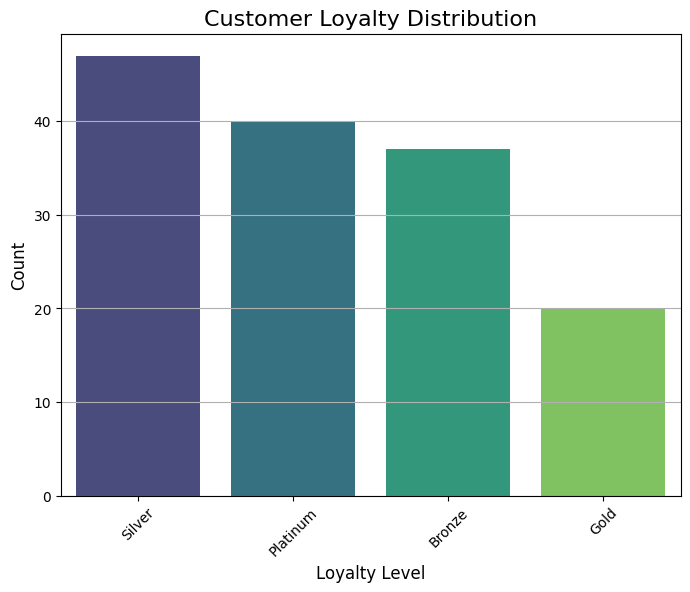

In [170]:
# Count of customer loyalty levels
loyalty_counts = df['customer_loyalty_level_<lambda>'].value_counts().reset_index()
loyalty_counts.columns = ['Loyalty Level', 'Count']

# Plot loyalty distribution
plt.figure(figsize=(8, 6))
sns.barplot(data=loyalty_counts, x='Loyalty Level', y='Count', palette='viridis')
plt.title('Customer Loyalty Distribution', fontsize=16)
plt.xlabel('Loyalty Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# We can appreciate a uniform distribution, but perhaps the imbalance in
# Gold might represent a problem, also we see most customers for this
# categories are high end market

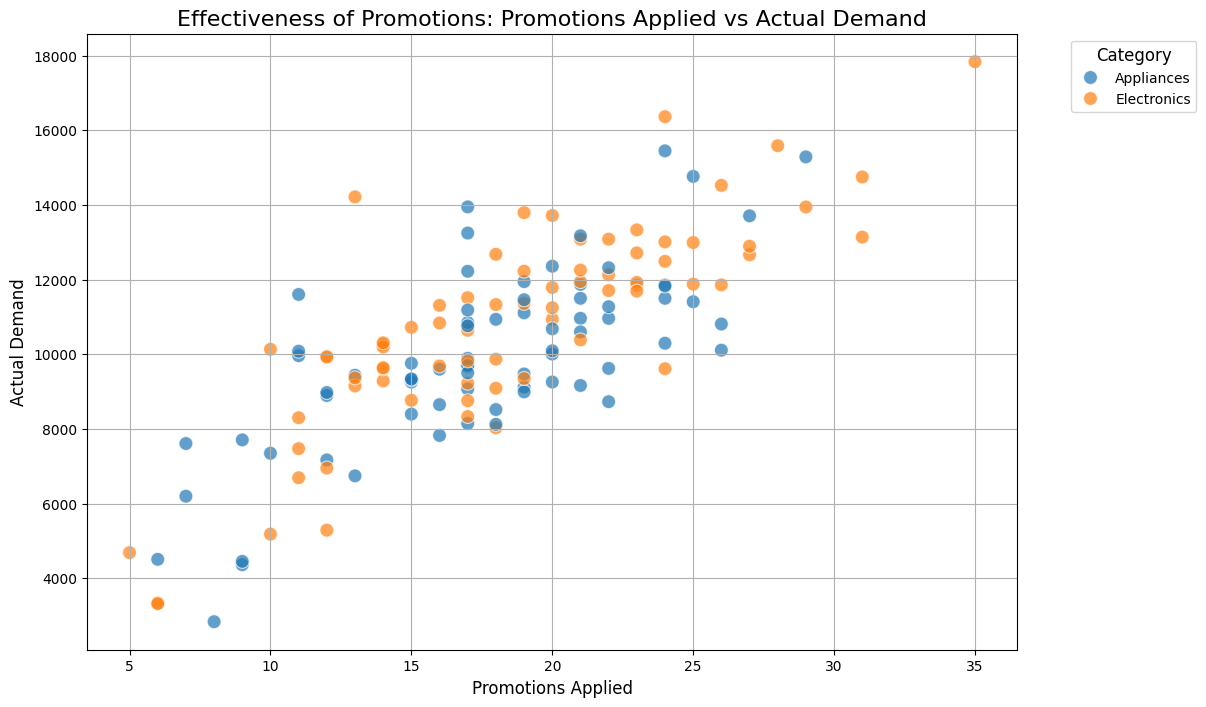

In [171]:
# Scatter plot of promotion applied vs. actual demand
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='promotion_applied_sum', y='actual_demand_sum', hue='category', s=100, alpha=0.7)
plt.title('Effectiveness of Promotions: Promotions Applied vs Actual Demand', fontsize=16)
plt.xlabel('Promotions Applied', fontsize=12)
plt.ylabel('Actual Demand', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

# Also we can se a positive relation with the promotions

### Looking for correlations

In [172]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix["actual_demand_sum"].sort_values(ascending=False)

actual_demand_sum          1.000000
transaction_id_nunique     0.971560
inventory_level_sum        0.923204
quantity_sold_sum          0.919312
stockout_indicator_sum     0.830679
holiday_indicator_sum      0.803445
promotion_applied_sum      0.783467
store_id_nunique           0.766830
store_location_nunique     0.265203
unit_price_mean            0.145967
reorder_point_mean         0.132938
supplier_lead_time_std     0.016870
customer_age_mean          0.014664
supplier_lead_time_mean    0.003247
reorder_quantity_mean     -0.003663
customer_age_std          -0.008031
customer_income_mean      -0.014870
customer_income_std       -0.037962
unit_price_std            -0.110670
Name: actual_demand_sum, dtype: float64

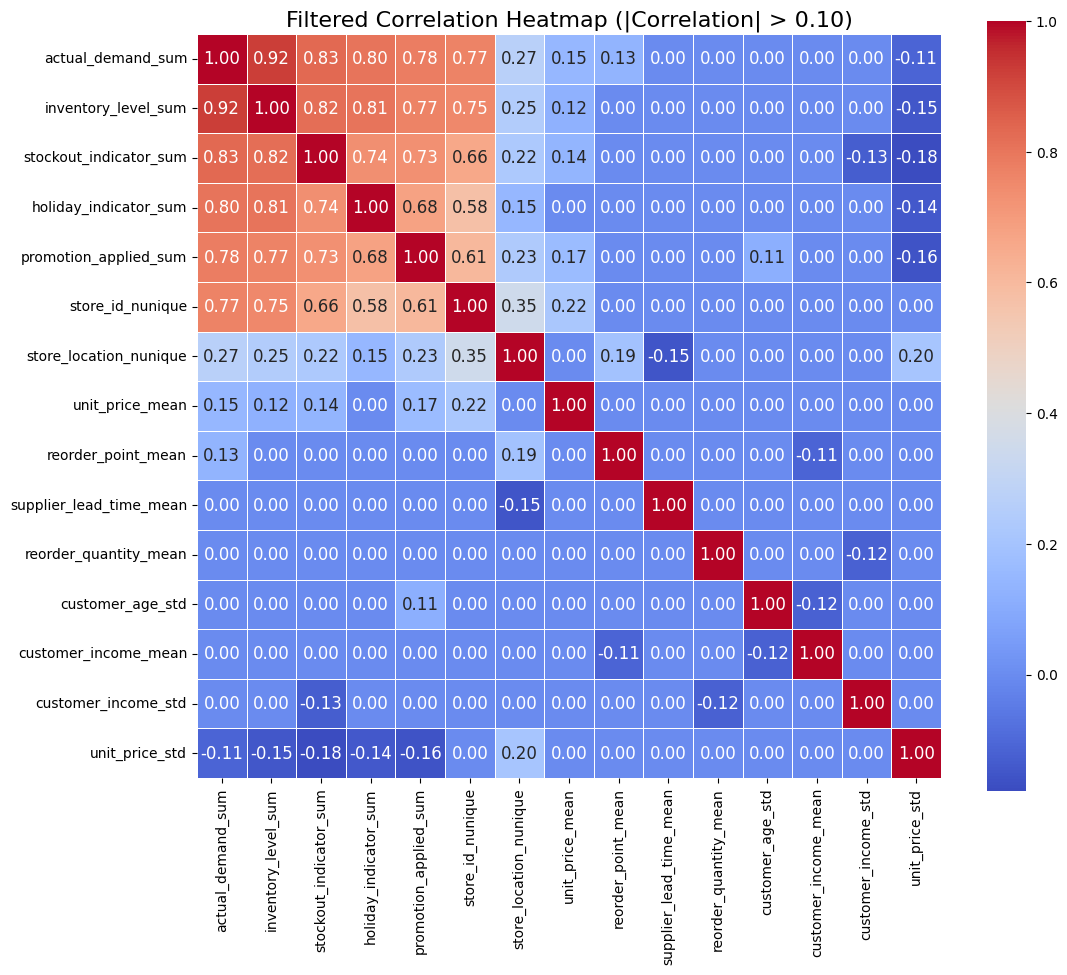

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for the selected attributes
attributes = ["actual_demand_sum", "inventory_level_sum", "stockout_indicator_sum",
              "holiday_indicator_sum", "promotion_applied_sum", "store_id_nunique",
              "store_location_nunique", "unit_price_mean", "reorder_point_mean",
              "supplier_lead_time_mean", "reorder_quantity_mean", "customer_age_std",
              "customer_income_mean", "customer_income_std", "unit_price_std"]

corr_matrix = df[attributes].corr()

# Filter correlations greater than 0.10 (absolute value)
filtered_corr = corr_matrix[corr_matrix.abs() > 0.10].fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True, linewidths=0.5)
plt.title("Filtered Correlation Heatmap (|Correlation| > 0.10)", fontsize=16)
plt.show()


### Prepare data for machine learning algorithms

In [174]:
# Count the number of null values in each column of the DataFrame
null_counts = df.isnull().sum().reset_index()
null_counts.columns = ['Column', 'Null Count']

# Display the null counts
print(null_counts)

# Although we do not have null values in the code below a provide a method to
# clean the data for nulls

                             Column  Null Count
0                            period           0
1                          category           0
2                      product_name           0
3            transaction_id_nunique           0
4                 quantity_sold_sum           0
5                   unit_price_mean           0
6                    unit_price_std           0
7                  store_id_nunique           0
8            store_location_nunique           0
9               inventory_level_sum           0
10               reorder_point_mean           0
11            reorder_quantity_mean           0
12          supplier_lead_time_mean           0
13           supplier_lead_time_std           0
14                customer_age_mean           0
15                 customer_age_std           0
16             customer_income_mean           0
17              customer_income_std           0
18            promotion_applied_sum           0
19            holiday_indicator_sum     

In [175]:
null_rows_idx = df.isnull().any(axis=1)
df.loc[null_rows_idx].head()

,period,category,product_name,transaction_id_nunique,quantity_sold_sum,unit_price_mean,unit_price_std,store_id_nunique,store_location_nunique,inventory_level_sum,reorder_point_mean,reorder_quantity_mean,supplier_lead_time_mean,supplier_lead_time_std,customer_age_mean,customer_age_std,customer_income_mean,customer_income_std,promotion_applied_sum,holiday_indicator_sum,stockout_indicator_sum,actual_demand_sum,payment_method_<lambda>,promotion_type_<lambda>,weather_conditions_<lambda>,weekday_<lambda>,customer_loyalty_level_<lambda>,customer_gender_<lambda>


In [176]:
df_cleaning = df.drop("actual_demand_sum", axis=1)
df_labels = df["actual_demand_sum"].copy()

#### Data cleaning fill by median

In [177]:
# Select numeric columns
data_num = df_cleaning.select_dtypes(include=[np.number])

for col in data_num:
    # Impute missing values with the median for each period
    data[col] = df_cleaning.groupby('period')[col].apply(lambda x: x.fillna(x.median())).reset_index(level=0, drop=True)


In [178]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

imputer.fit(data_num)


SimpleImputer(strategy='median')

In [179]:
imputer.statistics_

array([3.50000000e+01, 1.04000000e+02, 1.02290895e+03, 5.62372502e+02,
       1.70000000e+01, 5.00000000e+00, 8.85700000e+03, 9.96151316e+01,
       2.00735397e+02, 5.50000000e+00, 2.86778230e+00, 4.43697917e+01,
       1.53301141e+01, 6.98128184e+04, 2.91062923e+04, 1.80000000e+01,
       1.70000000e+01, 1.80000000e+01])

In [180]:
#Verifying same numerical values 
data_num.median().values

array([3.50000000e+01, 1.04000000e+02, 1.02290895e+03, 5.62372502e+02,
       1.70000000e+01, 5.00000000e+00, 8.85700000e+03, 9.96151316e+01,
       2.00735397e+02, 5.50000000e+00, 2.86778230e+00, 4.43697917e+01,
       1.53301141e+01, 6.98128184e+04, 2.91062923e+04, 1.80000000e+01,
       1.70000000e+01, 1.80000000e+01])

In [181]:
# Transforming the data set
X = imputer.transform(data_num)

imputer.feature_names_in_


array(['transaction_id_nunique', 'quantity_sold_sum', 'unit_price_mean',
       'unit_price_std', 'store_id_nunique', 'store_location_nunique',
       'inventory_level_sum', 'reorder_point_mean',
       'reorder_quantity_mean', 'supplier_lead_time_mean',
       'supplier_lead_time_std', 'customer_age_mean', 'customer_age_std',
       'customer_income_mean', 'customer_income_std',
       'promotion_applied_sum', 'holiday_indicator_sum',
       'stockout_indicator_sum'], dtype=object)

In [182]:
data_tr = pd.DataFrame(X, columns= data_num.columns, index=data_num.index)

data_tr.loc[null_rows_idx].head()

,transaction_id_nunique,quantity_sold_sum,unit_price_mean,unit_price_std,store_id_nunique,store_location_nunique,inventory_level_sum,reorder_point_mean,reorder_quantity_mean,supplier_lead_time_mean,supplier_lead_time_std,customer_age_mean,customer_age_std,customer_income_mean,customer_income_std,promotion_applied_sum,holiday_indicator_sum,stockout_indicator_sum


In [183]:
imputer.strategy

'median'

#### Handling outliers

In [184]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

outlier_pred

df_cleaning = df_cleaning.iloc[outlier_pred == 1]
df_labels = df_labels.iloc[outlier_pred == 1]

#### Handling text and categorical attributes

In [185]:
df_cat = df[["customer_loyalty_level_<lambda>"]]
df_cat.head(8)

,customer_loyalty_level_<lambda>
0,Gold
1,Silver
2,Bronze
3,Silver
4,Silver
5,Gold
6,Silver
7,Platinum


In [186]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)

df_cat_encoded[:8]


array([[1.],
       [3.],
       [0.],
       [3.],
       [3.],
       [1.],
       [3.],
       [2.]])

In [187]:
ordinal_encoder.categories_

[array(['Bronze', 'Gold', 'Platinum', 'Silver'], dtype=object)]

In [188]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_cat)

df_cat_1hot

df_cat_1hot.toarray()

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],


In [189]:
cat_encoder.categories_

[array(['Bronze', 'Gold', 'Platinum', 'Silver'], dtype=object)]

In [190]:
df_test = pd.DataFrame({"customer_loyalty_level_<lambda>": ["Bronze", "Platinum"]})
pd.get_dummies(df_test)

,customer_loyalty_level_<lambda>_Bronze,customer_loyalty_level_<lambda>_Platinum
0,True,False
1,False,True


In [191]:
cat_encoder.transform(df_test)

<2x4 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [192]:
df_test_unknown = pd.DataFrame({"customer_loyalty_level_<lambda>": [ "Bronze", "Copper",]})
pd.get_dummies(df_test_unknown)

,customer_loyalty_level_<lambda>_Bronze,customer_loyalty_level_<lambda>_Copper
0,True,False
1,False,True


In [193]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)
cat_encoder.feature_names_in_
cat_encoder.get_feature_names_out()

array(['customer_loyalty_level_<lambda>_Bronze',
       'customer_loyalty_level_<lambda>_Gold',
       'customer_loyalty_level_<lambda>_Platinum',
       'customer_loyalty_level_<lambda>_Silver'], dtype=object)

In [194]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(), 
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output

,customer_loyalty_level_<lambda>_Bronze,customer_loyalty_level_<lambda>_Gold,customer_loyalty_level_<lambda>_Platinum,customer_loyalty_level_<lambda>_Silver
0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0


In [195]:
# Function for products and appliences 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
class CustomCategoryEncoder(BaseEstimator, TransformerMixin):
    """
    Custom encoder for category and product_name columns with known categories
    """
    def __init__(self, handle_unknown='ignore'):
        self.handle_unknown = handle_unknown
        self.category_mapping = {
            'category': ['Appliances', 'Electronics'],
            'product_name': ['Camera', 'Fridge', 'Headphones', 'Laptop', 
                           'Smartphone', 'TV', 'Tablet', 'Washing Machine']
        }
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown=handle_unknown)
        
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.encoder.fit(X)
        self.feature_names_in_ = X.columns
        return self
        
    def transform(self, X):
        X = pd.DataFrame(X)
        return self.encoder.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        return self.encoder.get_feature_names_out(input_features)

In [196]:
# Function for gender
class CustomerAttributeEncoder(BaseEstimator, TransformerMixin):
    """
    Encoder for customer-related categories (gender)
    """
    def __init__(self, handle_unknown='ignore'):
        self.handle_unknown = handle_unknown
        self.gender_categories = ['Male', 'Female', 'Other']
        
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.feature_names_in_ = X.columns
        
        self.gender_encoder = OneHotEncoder(
            sparse_output=False,
            handle_unknown=self.handle_unknown
        )

        gender_cols = [col for col in X.columns if 'gender' in col.lower()]

        self.gender_encoder.fit(X[gender_cols])
            
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X)
        gender_cols = [col for col in X.columns if 'gender' in col.lower()]
        if not gender_cols:
            return np.zeros((X.shape[0], len(self.gender_categories)))
        return self.gender_encoder.transform(X[gender_cols])
    
    def get_feature_names_out(self, input_features=None):
        return [f'gender_{cat}' for cat in self.gender_categories]
    


In [197]:
# Encoder for payment methods
class PaymentMethodEncoder(BaseEstimator, TransformerMixin):
    """Encoder for payment methods"""
    def __init__(self, handle_unknown='ignore'):
        self.handle_unknown = handle_unknown
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown=handle_unknown)
        
    def fit(self, X, y=None):
        self.encoder.fit(X)
        self.feature_names_in_ = X.columns
        return self
        
    def transform(self, X):
        return self.encoder.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        return self.encoder.get_feature_names_out(input_features)

In [198]:
# Encoder for promotion type
class PromotionTypeEncoder(BaseEstimator, TransformerMixin):
    """Encoder for promotion types"""
    def __init__(self, handle_unknown='ignore'):
        self.handle_unknown = handle_unknown
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown=handle_unknown)
        
    def fit(self, X, y=None):
        self.encoder.fit(X)
        self.feature_names_in_ = X.columns
        return self
        
    def transform(self, X):
        return self.encoder.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        return self.encoder.get_feature_names_out(input_features)

In [199]:
# Encoder for weather conditions
class WeatherConditionsEncoder(BaseEstimator, TransformerMixin):
    """Encoder for weather conditions"""
    def __init__(self, handle_unknown='ignore'):
        self.handle_unknown = handle_unknown
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown=handle_unknown)
        
    def fit(self, X, y=None):
        self.encoder.fit(X)
        self.feature_names_in_ = X.columns
        return self
        
    def transform(self, X):
        return self.encoder.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        return self.encoder.get_feature_names_out(input_features)


In [200]:
#  Encoder for weekday
class WeekdayEncoder(BaseEstimator, TransformerMixin):
    """Encoder for weekdays using ordinal encoding"""
    def __init__(self):
        self.weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                             'Friday', 'Saturday', 'Sunday']
        self.encoder = OrdinalEncoder(
            categories=[self.weekday_order],
            handle_unknown='use_encoded_value',
            unknown_value=-1
        )
        
    def fit(self, X, y=None):
        self.encoder.fit(X)
        self.feature_names_in_ = X.columns
        return self
        
    def transform(self, X):
        return self.encoder.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        return np.array(['weekday_ordinal'])

#### Feature Scaling

In [201]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
df_num_min_max_scaled = min_max_scaler.fit_transform(data_num)

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
df_num_std_scaled = std_scaler.fit_transform(data_num)


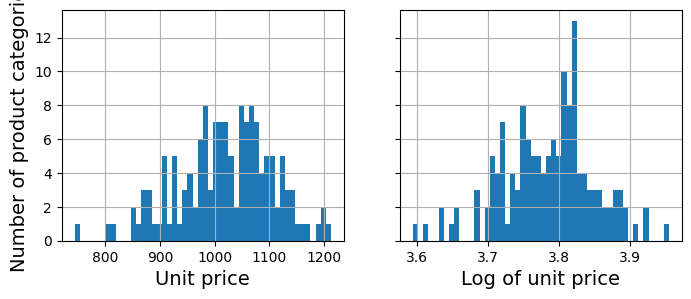

In [202]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
df["unit_price_mean"].hist(ax=axs[0], bins=50)
df["customer_age_mean"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Unit price")
axs[1].set_xlabel("Log of unit price")
axs[0].set_ylabel("Number of product categories")
plt.show()

In [203]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(df_labels.to_frame())

model = LinearRegression()
model.fit(df_cleaning[["unit_price_mean"]], scaled_labels)
some_new_data = df_cleaning[["unit_price_mean"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

predictions

array([[10804.27862215],
       [10844.99694128],
       [10850.89629661],
       [10848.07618304],
       [10826.52144504]])

In [204]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(df_cleaning[["unit_price_mean"]], df_labels)
predictions = model.predict(some_new_data)

predictions

array([10804.27862215, 10844.99694128, 10850.89629661, 10848.07618304,
       10826.52144504])

#### Custom transformers

In [205]:
#Function to apply natural log
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(df[["unit_price_mean"]])

In [206]:
#Function to apply radial basis function for age similitud 
from sklearn.metrics.pairwise import rbf_kernel

age_simil_40 = rbf_kernel(df[["customer_age_mean"]], [[40]], gamma=0.1)

rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[40.]], gamma=0.1))
age_simil_40 = rbf_transformer.transform(df[["customer_age_mean"]])

In [207]:
# Fucntion to apply the ratio of two columns
def create_ratio_transformer():
    return FunctionTransformer(
        lambda X: X[:, [0]] / X[:, [1]],
        feature_names_out='one-to-one'
    )

In [208]:
# Function to scale numerica variables
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

numeric_features_to_scale = [
    "quantity_sold_sum", 
    "unit_price_mean", "unit_price_std", 
    "store_location_nunique", "inventory_level_sum", "reorder_point_mean",
    "reorder_quantity_mean", "supplier_lead_time_mean", "supplier_lead_time_std",
    "customer_age_mean", "customer_age_std", "customer_income_mean",
    "customer_income_std", "promotion_applied_sum", "holiday_indicator_sum",
    "stockout_indicator_sum", "actual_demand_sum"
]

datetime_features = ["period"]

#Function to impement a custom standar scaler 
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # Only calculate statistics for numeric columns
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        self.numeric_cols_ = numeric_cols
        self.mean_ = X[numeric_cols].mean()
        self.scale_ = X[numeric_cols].std()
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        X_copy = X.copy()
        # Only transform numeric columns
        if self.with_mean:
            X_copy[self.numeric_cols_] = (X_copy[self.numeric_cols_] - self.mean_)
        X_copy[self.numeric_cols_] = X_copy[self.numeric_cols_] / self.scale_
        return X_copy

In [209]:
# Function to create cluster similarites
from sklearn.cluster import KMeans
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    
    

X_filtered = X[outlier_pred == 1, :]

#Re-fit cluster similarity on the filtered dataset:
cs = ClusterSimilarity(n_clusters=2, gamma=1.0, random_state=42)
cs.fit(X_filtered)
similarities = cs.transform(X_filtered)

df_cleaning["Max cluster similarity"] = similarities.max(axis=1)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [210]:
# Function to apply MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Scale using MinMaxScaler to constrain features between 0 and 1
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_cleaning[["quantity_sold_sum", "unit_price_mean"]])

# Add maximum similarity to the DataFrame
df_cleaning["Max cluster similarity"] = similarities.max(axis=1)

# Check the first few rows of the scaled features and similarities
print(scaled_features[:3])  # Scaled features
print(similarities[:3].round(2))  # Similarities


[[0.27       0.38760752]
 [0.58       0.60496411]
 [0.24       0.63645519]]
[[0. 0.]
 [0. 0.]
 [0. 0.]]


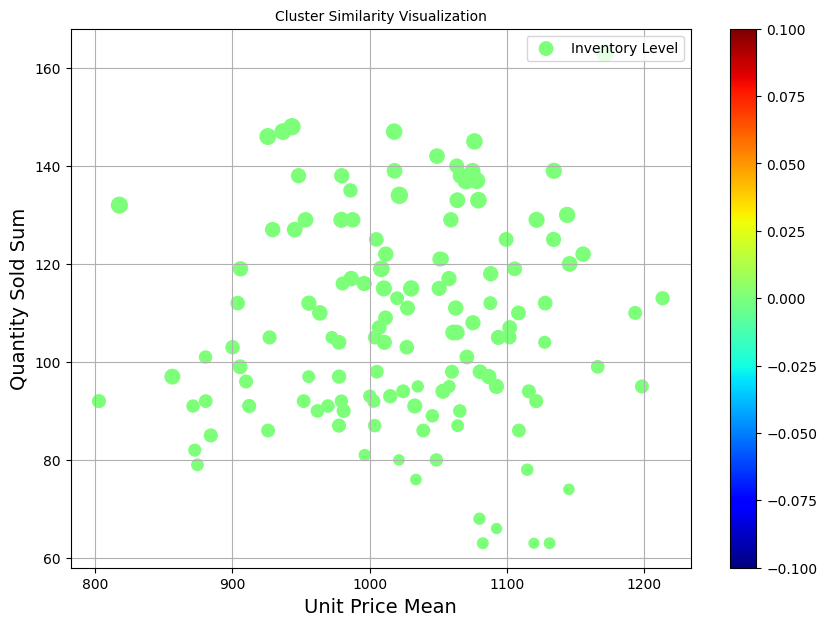

In [211]:
# Transform cluster centers back to the original scale
#original_cluster_centers = scaler.inverse_transform(cs.kmeans_.cluster_centers_)

# Scatter plot with original data
df_cleaning.plot(
    kind="scatter",
    x="unit_price_mean",  # X-axis
    y="quantity_sold_sum",  # Y-axis
    grid=True,
    s=df_cleaning["inventory_level_sum"] / 100,  # Scale point size
    label="Inventory Level",
    c=df_cleaning["Max cluster similarity"],  # Color by max similarity
    cmap="jet",  # Colormap for similarity
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7),
)



plt.legend(loc="upper right")
plt.title("Cluster Similarity Visualization")
plt.xlabel("Unit Price Mean")
plt.ylabel("Quantity Sold Sum")
plt.show()


In [212]:
# Class to transform the period 
class PeriodTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_out = None
        
    def fit(self, X, y=None):
        if 'period' in X.columns:
            self.feature_names_out = ['period_month']
        else:
            self.feature_names_out = []
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X)
        X_transformed = X.copy()
        if 'period' in X.columns:
            X_transformed['period_month'] = X['period'].apply(lambda x: int(str(x).split('-')[1]))
            X_transformed = X_transformed.drop('period', axis=1)
        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        # Return the stored feature names
        if self.feature_names_out is None:
            raise ValueError("Transformer not fitted. Call 'fit' before using this method.")
        return np.array(self.feature_names_out)

In [213]:
# Class Lag feature
class LagFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, agg_level=None, lag=1):
        self.lag = lag
        self.agg_level = agg_level if agg_level is not None else ["period"]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X)
        result = X.copy()
        
        try:
            if "period" in X.columns:
                # Convert period to month number
                current_months = X["period"].str.split('-').str[1].astype(int)
                
                # Create lag periods
                lag_months = current_months - self.lag
                
                # Create lag features for numeric columns
                numeric_cols = X.select_dtypes(include=[np.number]).columns
                for col in numeric_cols:
                    if col != "period":
                        # Create mapping of values by month
                        month_values = X.groupby(current_months)[col].mean()
                        # Map lagged values
                        result[f"{col}_lag_{self.lag}"] = lag_months.map(
                            month_values.to_dict()
                        ).fillna(0)
            
            return result
        except Exception as e:
            print(f"Error in LagFeatures: {str(e)}")
            return X

In [214]:
df_lag = df.groupby(["period","category"]).agg(
    {
        "actual_demand_sum":"sum"
    }
).reset_index()

df_lag["lag_period"] = "2024-" + (df_lag["period"].str.split("-",expand=True)[1].astype(int) + 1).astype(str)
df_lag = df_lag.rename(columns={"actual_demand_sum":"lag_actual_demand_sum"})
df.merge(df_lag[["lag_period","category","lag_actual_demand_sum"]],left_on=["period","category"],right_on=["lag_period","category"],how="left")

,period,category,product_name,transaction_id_nunique,quantity_sold_sum,unit_price_mean,unit_price_std,store_id_nunique,store_location_nunique,inventory_level_sum,reorder_point_mean,reorder_quantity_mean,supplier_lead_time_mean,supplier_lead_time_std,customer_age_mean,customer_age_std,customer_income_mean,customer_income_std,promotion_applied_sum,holiday_indicator_sum,stockout_indicator_sum,actual_demand_sum,payment_method_<lambda>,promotion_type_<lambda>,weather_conditions_<lambda>,weekday_<lambda>,customer_loyalty_level_<lambda>,customer_gender_<lambda>,lag_period,lag_actual_demand_sum
0,2024-1,Appliances,Camera,32,90,961.859687,482.023642,15,5,7803,101.562500,205.875000,4.250000,2.449490,40.781250,15.685897,69886.930313,27081.270071,17,17,14,9072,Digital Wallet,Percentage Discount,Sunny,Tuesday,Gold,Male,NaN,NaN
1,2024-1,Appliances,Fridge,37,121,1051.071892,613.425258,18,5,9857,99.972973,204.243243,4.864865,2.689095,46.648649,14.890743,69738.706486,33220.223306,24,16,19,11856,Digital Wallet,BOGO,Stormy,Monday,Silver,Male,NaN,NaN
2,2024-1,Appliances,Headphones,28,87,1063.997143,484.223750,16,5,6794,100.642857,170.678571,5.678571,3.266594,42.642857,16.746949,64773.744286,26486.203589,16,15,17,7826,Cash,BOGO,Stormy,Thursday,Bronze,Female,NaN,NaN
3,2024-1,Appliances,Laptop,31,95,1057.818387,542.003713,16,5,6942,101.000000,198.677419,5.806452,3.092134,43.322581,16.612018,74511.939677,28040.773305,17,14,12,9668,Cash,BOGO,Cloudy,Monday,Silver,Male,NaN,NaN
4,2024-1,Appliances,Smartphone,39,104,1010.592821,579.002171,17,5,9867,102.282051,195.153846,5.461538,2.614194,45.615385,15.424887,71179.089231,26702.546264,22,19,18,10961,Cash,Percentage Discount,Sunny,Friday,Silver,Other,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024-9,Electronics,Laptop,14,52,857.420714,451.092902,10,5,3543,95.785714,174.142857,5.500000,2.409915,45.142857,14.373358,60476.030714,28088.018443,6,9,8,3344,Digital Wallet,BOGO,Sunny,Thursday,Silver,Male,2024-9,99272.0
140,2024-9,Electronics,Smartphone,16,57,1057.263750,560.338051,10,4,4743,88.687500,217.625000,5.937500,3.255124,41.187500,14.105407,68343.923125,29252.283524,5,13,9,4688,Cash,Percentage Discount,Cloudy,Saturday,Bronze,Other,2024-9,99272.0
141,2024-9,Electronics,TV,12,38,988.708333,662.025446,10,5,2620,90.083333,184.583333,5.916667,2.503028,38.333333,13.040729,66994.302500,25637.757510,6,7,7,3321,Debit Card,Percentage Discount,Sunny,Thursday,Silver,Female,2024-9,99272.0
142,2024-9,Electronics,Tablet,18,56,1049.402222,517.298871,11,5,4712,97.722222,229.777778,5.111111,3.007616,41.166667,16.589330,80726.546111,29621.854559,12,10,9,5290,Credit Card,Percentage Discount,Rainy,Wednesday,Platinum,Other,2024-9,99272.0


In [215]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import set_config
set_config(display='diagram')



def create_pipeline():
    # Separate features by type
    numeric_features = [
        "quantity_sold_sum", 
        "unit_price_mean", "unit_price_std", 
        "store_location_nunique", "inventory_level_sum", "reorder_point_mean",
        "reorder_quantity_mean", "supplier_lead_time_mean", "supplier_lead_time_std",
        "customer_age_mean", "customer_age_std", "customer_income_mean",
        "customer_income_std", "promotion_applied_sum", "holiday_indicator_sum",
        "stockout_indicator_sum"
    ]
    
    categorical_features = [
        "category", "product_name", "payment_method_<lambda>",
        "promotion_type_<lambda>", "weather_conditions_<lambda>",
        "weekday_<lambda>", "customer_loyalty_level_<lambda>",
        "customer_gender_<lambda>"
    ]
    
    period_features = ["period"]
    
    # Create transformers
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    period_transformer = Pipeline([
        ('period_transform', PeriodTransformer()),
        ('scaler', StandardScaler())
    ])
    
    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('period', period_transformer, period_features)
        ],
        remainder='drop'
    )
    
    # Create full pipeline
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', HistGradientBoostingRegressor(random_state=42))
    ])
    
    return full_pipeline, numeric_features, categorical_features, period_features

# preprocessor.fit_transform(df[["period_","unit_price_mean", "actual_demand_sum","unit_price_std","inventory_level_sum","customer_age_mean","customer_age_std","customer_income_mean","customer_income_std"] +["category_", "product_name_"] ])

In [216]:
from sklearn.metrics import mean_absolute_error

def cross_validation(df, cv=3):
    # Create pipeline
    pipeline, numeric_features, categorical_features, period_features = create_pipeline()
    
    # Get all features
    features_to_use = numeric_features + categorical_features + period_features
    
    try:
        periodos = sorted(df["period"].unique(), reverse=True)    
        metrics = {}
        
        for i in range(1, cv+1):
            print(f"\nFold {i}")
            
            # Split data
            if i != 1:
                test = df[df["period"].isin([periodos[:i][i-1]])]
                train = df[~df["period"].isin(periodos[:i])]
            else:
                test = df[df["period"].isin(periodos[:i])]
                train = df[~df["period"].isin(periodos[:i])]
            
            print("Train periods:", train["period"].unique())
            print("Test period:", test["period"].unique())
            
            # Prepare features
            X_train = train[features_to_use]
            y_train = train["actual_demand_sum"]
            X_test = test[features_to_use]
            y_test = test["actual_demand_sum"]
            
            # Fit and predict
            pipeline.fit(X_train, y_train)
            predictions = pipeline.predict(X_test)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, predictions)
            metrics[i] = mae
            print(f"MAE for fold {i}: {mae:.2f}")
        
        return metrics
    
    except Exception as e:
        print(f"Error in cross validation: {str(e)}")
        raise

metrics = cross_validation(df, cv=3)



Fold 1
Train periods: ['2024-1' '2024-2' '2024-3' '2024-4' '2024-5' '2024-6' '2024-7' '2024-8']
Test period: ['2024-9']
MAE for fold 1: 3116.27

Fold 2
Train periods: ['2024-1' '2024-2' '2024-3' '2024-4' '2024-5' '2024-6' '2024-7']
Test period: ['2024-8']
MAE for fold 2: 1240.45

Fold 3
Train periods: ['2024-1' '2024-2' '2024-3' '2024-4' '2024-5' '2024-6']
Test period: ['2024-7']
MAE for fold 3: 672.87


In [217]:
# We add a new class for ARIMA model since it's a well known model for time series forecasting
from sklearn.base import BaseEstimator, RegressorMixin

class ARIMARegressor(BaseEstimator, RegressorMixin):
    def __init__(self, p=1, d=0, q=0):
        self.p = p
        self.d = d
        self.q = q
        self.model = None
        self.freq = None
        
    def _prepare_time_series(self, X, y):
        """Convert data to proper time series format with frequency"""
        periods = pd.to_datetime(X['period'].apply(lambda x: f"{x}-01"))  # Add day for proper datetime
        
        # Create time series with proper frequency
        ts_data = pd.Series(y.values, index=periods)
        ts_data = ts_data.sort_index()
        
        if self.freq is None:
            self.freq = pd.infer_freq(ts_data.index)
            if self.freq is None:
                self.freq = 'M'
                ts_data.index.freq = self.freq
        
        return ts_data
        
    def fit(self, X, y):
        try:
            # Prepare time series data
            ts_data = self._prepare_time_series(X, y)
            
            # Fit ARIMA model
            self.model = ARIMA(ts_data, order=(self.p, self.d, self.q), freq=self.freq)
            self.results_ = self.model.fit()
            return self
        except Exception as e:
            print(f"Error fitting ARIMA model: {str(e)}")
            raise
        
    def predict(self, X):
        try:
            if self.model is None:
                raise ValueError("Model has not been fitted yet.")
            
            # Convert prediction dates to proper format
            forecast_index = pd.to_datetime(X['period'].apply(lambda x: f"{x}-01"))
            forecast_index = pd.date_range(
                start=forecast_index.min(),
                end=forecast_index.max(),
                freq=self.freq
            )
            
            # Generate predictions
            predictions = self.results_.predict(
                start=forecast_index[0],
                end=forecast_index[-1],
                dynamic=False
            )
            
            return predictions.values
        except Exception as e:
            print(f"Error in ARIMA prediction: {str(e)}")
            raise



In [218]:
def evaluate_arima_model(X, y, cv=3):
    """Separate function to evaluate ARIMA model with proper time series CV"""
    try:
        arima_errors = []
        unique_periods = sorted(X['period'].unique())
        n_splits = min(cv, len(unique_periods) - 1)
        
        for i in range(n_splits):
            # Split data while maintaining time order
            split_point = len(unique_periods) - i - 1
            train_periods = unique_periods[:split_point]
            test_period = unique_periods[split_point]
            
            print(f"\nValidation fold {i+1}:")
            print(f"Training periods: {train_periods}")
            print(f"Test period: {test_period}")
            
            # Prepare train/test splits
            train_mask = X['period'].isin(train_periods)
            test_mask = X['period'] == test_period
            
            X_train, X_test = X[train_mask], X[test_mask]
            y_train, y_test = y[train_mask], y[test_mask]
            
            # Try different ARIMA configurations
            orders = [
                (1,1,1), (1,1,0), (0,1,1),
                (1,0,1), (1,0,0), (0,1,0)
            ]
            
            best_rmse = float('inf')
            best_order = None
            
            for order in orders:
                try:
                    arima = ARIMARegressor(p=order[0], d=order[1], q=order[2])
                    arima.fit(X_train, y_train)
                    predictions = arima.predict(X_test)
                    
                    rmse = np.sqrt(mean_squared_error(y_test, predictions))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = order
                except Exception as e:
                    print(f"Failed for order {order}: {str(e)}")
                    continue
            
            if best_order is not None:
                print(f"Best ARIMA order for fold {i+1}: {best_order}")
                print(f"RMSE: {best_rmse:.2f}")
                arima_errors.append(best_rmse)
            else:
                print(f"No valid ARIMA model found for fold {i+1}")
        
        if arima_errors:
            print("\nOverall ARIMA Performance:")
            print(pd.Series(arima_errors).describe())
            return {
                'RMSE': pd.Series(arima_errors).describe(),
                'model': ARIMARegressor(p=1, d=1, q=1)  # Default model
            }
        else:
            print("No valid ARIMA results obtained")
            return None
            
    except Exception as e:
        print(f"Error in ARIMA evaluation: {str(e)}")
        return None


In [219]:
# Function to evaluate models 
def evaluate_models(X, y, pipeline, cv=3):
    results = {}
    
    # Linear Regression with our pipeline
    lin_reg = Pipeline([
        ('preprocessor', pipeline.named_steps['preprocessor']),
        ('regressor', LinearRegression())
    ])
    lin_rmses = -cross_val_score(lin_reg, X, y,
                                scoring="neg_root_mean_squared_error", cv=cv)
    results['Linear Regression'] = {
        'RMSE': pd.Series(lin_rmses).describe(),
        'pipeline': lin_reg
    }
    print("Linear Regression RMSE:", pd.Series(lin_rmses).describe())
    
    # Decision Tree with our pipeline
    tree_reg = Pipeline([
        ('preprocessor', pipeline.named_steps['preprocessor']),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ])
    tree_rmses = -cross_val_score(tree_reg, X, y,
                                 scoring="neg_root_mean_squared_error", cv=cv)
    results['Decision Tree'] = {
        'RMSE': pd.Series(tree_rmses).describe(),
        'pipeline': tree_reg
    }
    print("\nDecision Tree RMSE:", pd.Series(tree_rmses).describe())
    
    # Random Forest with our pipeline
    forest_reg = Pipeline([
        ('preprocessor', pipeline.named_steps['preprocessor']),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    forest_rmses = -cross_val_score(forest_reg, X, y,
                                   scoring="neg_root_mean_squared_error", cv=cv)
    results['Random Forest'] = {
        'RMSE': pd.Series(forest_rmses).describe(),
        'pipeline': forest_reg
    }
    print("\nRandom Forest RMSE:", pd.Series(forest_rmses).describe())
    
    # ARIMA model evaluation 
    print("\nEvaluating ARIMA model...")
    arima_results = evaluate_arima_model(X, y, cv=cv)
    if arima_results is not None:
        results['ARIMA'] = arima_results

    
    return results

In [220]:
#Grid Search function 
def grid_search_best_model(X, y, best_base_model, pipeline):
    if isinstance(best_base_model, ARIMARegressor):
        # Grid search for ARIMA parameters
        param_grid = [
            {'p': [0, 1, 2],
             'd': [0, 1],
             'q': [0, 1, 2]}
        ]
        
        best_rmse = float('inf')
        best_params = None
        
        # Manual grid search for ARIMA
        for p in param_grid[0]['p']:
            for d in param_grid[0]['d']:
                for q in param_grid[0]['q']:
                    try:
                        arima = ARIMARegressor(p=p, d=d, q=q)
                        # Use the last period as validation
                        train_mask = X['period'] != X['period'].max()
                        test_mask = X['period'] == X['period'].max()
                        
                        arima.fit(X[train_mask], y[train_mask])
                        predictions = arima.predict(X[test_mask])
                        
                        rmse = np.sqrt(mean_squared_error(y[test_mask], predictions))
                        
                        if rmse < best_rmse:
                            best_rmse = rmse
                            best_params = {'p': p, 'd': d, 'q': q}
                            
                    except Exception as e:
                        continue
        
        print("Best ARIMA parameters:", best_params)
        print("Best RMSE:", best_rmse)
        
        return {'best_params': best_params, 'best_rmse': best_rmse}
    
    else:
        # Use previous grid search logic for other models
        if isinstance(best_base_model, RandomForestRegressor):
            param_grid = [
                {'random_forest__n_estimators': [100, 200, 300],
                 'random_forest__max_features': [4, 6, 8],
                 'random_forest__max_depth': [10, 20, None]}
            ]
            estimator_name = 'random_forest'
        elif isinstance(best_base_model, DecisionTreeRegressor):
            param_grid = [
                {'decision_tree__max_depth': [5, 10, 15, None],
                 'decision_tree__min_samples_split': [2, 5, 10]}
            ]
            estimator_name = 'decision_tree'
        else:  # Linear Regression
            param_grid = [{}]  # No parameters to tune for linear regression
            estimator_name = 'linear'
        
        full_pipeline = Pipeline([
            ('preprocessor', pipeline.named_steps['preprocessor']),
            (estimator_name, best_base_model)
        ])
        
        grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                                 scoring='neg_root_mean_squared_error')
        grid_search.fit(X, y)
        
        return grid_search

In [221]:
# Main function to run the complete pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

def run_full_modeling_pipeline(df):
    # Create pipeline using our previous function
    pipeline, numeric_features, categorical_features, period_features = create_pipeline()
    
    # Prepare features and target
    features_to_use = numeric_features + categorical_features + period_features
    X = df[features_to_use]
    y = df["actual_demand_sum"]
    
    # Evaluate all models including ARIMA
    model_results = evaluate_models(X, y, pipeline)
    
    # Select best model based on mean RMSE
    best_model_name = min(model_results.items(), 
                         key=lambda x: x[1]['RMSE']['mean'])[0]
    print(f"\nBest model: {best_model_name}")
    
    # Get best base model
    if best_model_name == 'ARIMA':
        best_base_model = model_results[best_model_name]['model']
    else:
        best_base_model = model_results[best_model_name]['pipeline'].named_steps['regressor']
    
    # Perform grid search on best model
    print("\nPerforming grid search...")
    grid_search_results = grid_search_best_model(X, y, best_base_model, pipeline)
    
    return {
        'model_evaluation': model_results,
        'grid_search': grid_search_results
    }


results = run_full_modeling_pipeline(df)

Linear Regression RMSE: count    3.000000e+00
mean     5.032019e+14
std      8.715713e+14
min      1.047532e+03
25%      1.111359e+03
50%      1.175185e+03
75%      7.548029e+14
max      1.509606e+15
dtype: float64

Decision Tree RMSE: count       3.000000
mean     1537.857435
std       362.498639
min      1247.620844
25%      1334.696504
50%      1421.772163
75%      1682.975731
max      1944.179299
dtype: float64

Random Forest RMSE: count       3.000000
mean     1262.542757
std       692.664599
min       803.221803
25%       864.184547
50%       925.147292
75%      1492.203234
max      2059.259177
dtype: float64

Evaluating ARIMA model...

Validation fold 1:
Training periods: ['2024-1', '2024-2', '2024-3', '2024-4', '2024-5', '2024-6', '2024-7', '2024-8']
Test period: 2024-9
Error fitting ARIMA model: Inferred frequency None from passed values does not conform to passed frequency ME
Failed for order (1, 1, 1): Inferred frequency None from passed values does not conform to passed fre

C:\Users\Artur\AppData\Local\Temp\ipykernel_15596\2540102924.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data.index.freq = self.freq
C:\Users\Artur\AppData\Local\Temp\ipykernel_15596\2540102924.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data.index.freq = self.freq
C:\Users\Artur\AppData\Local\Temp\ipykernel_15596\2540102924.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data.index.freq = self.freq
C:\Users\Artur\AppData\Local\Temp\ipykernel_15596\2540102924.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data.index.freq = self.freq
C:\Users\Artur\AppData\Local\Temp\ipykernel_15596\2540102924.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data.index.freq = self.freq


In [222]:
from scipy import stats


def analyze_model_performance(model, X_train, X_test, y_train, y_test, confidence=0.95, model_type=None):
    """
    Analyze model performance with support for different model types
    """
    results = {}
    
    try:
        # Different handling for ARIMA vs other models
        if model_type == 'ARIMA':
            # Make predictions (ARIMA specific)
            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)
        else:
            # Handle feature importance for tree-based models
            if hasattr(model, 'named_steps') and 'regressor' in model.named_steps:
                if hasattr(model.named_steps['regressor'], 'feature_importances_'):
                    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
                    importances = model.named_steps['regressor'].feature_importances_
                    feature_importance = pd.DataFrame({
                        'feature': feature_names,
                        'importance': importances
                    }).sort_values('importance', ascending=False)
                    
                    results['feature_importance'] = feature_importance
                    
                    # Plot feature importance
                    plt.figure(figsize=(10, 6))
                    sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
                    plt.title('Top 20 Most Important Features')
                    plt.tight_layout()
                    plt.show()
            
            # Make predictions (standard models)
            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)
        
        # Calculate errors
        train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
        test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
        
        results['train_rmse'] = train_rmse
        results['test_rmse'] = test_rmse
        
        # Compute confidence intervals
        squared_errors = (test_predictions - y_test) ** 2
        m = len(squared_errors)
        mean = squared_errors.mean()
        
        tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
        tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
        ci_lower, ci_upper = np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)
        
        results['rmse_confidence_interval'] = (ci_lower, ci_upper)
        
        # Visualization
        # Actual vs Predicted
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, test_predictions, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted Demand ({model_type if model_type else "Model"})')
        plt.tight_layout()
        plt.show()
        
        # Error Distribution
        errors = test_predictions - y_test
        plt.figure(figsize=(10, 6))
        sns.histplot(errors, kde=True)
        plt.title(f'Distribution of Prediction Errors ({model_type if model_type else "Model"})')
        plt.xlabel('Prediction Error')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Warning: Error in performance analysis: {str(e)}")
        # Return partial results if available
        if not results:
            results['error'] = str(e)
    
    return results

def evaluate_models(X_train, y_train, pipeline):
    """Evaluate all models with error handling"""
    results = {}
    
    # Try Linear Regression
    try:
        print("\nEvaluating Linear Regression...")
        lin_reg = Pipeline([
            ('preprocessor', pipeline.named_steps['preprocessor']),
            ('regressor', LinearRegression())
        ])
        lin_rmses = -cross_val_score(lin_reg, X_train, y_train,
                                   scoring="neg_root_mean_squared_error", cv=3)
        results['Linear Regression'] = {
            'RMSE': pd.Series(lin_rmses).describe(),
            'pipeline': lin_reg
        }
        print("Linear Regression RMSE:", pd.Series(lin_rmses).describe())
    except Exception as e:
        print(f"Warning: Linear Regression failed: {str(e)}")
    
    # Try Decision Tree
    try:
        print("\nEvaluating Decision Tree...")
        tree_reg = Pipeline([
            ('preprocessor', pipeline.named_steps['preprocessor']),
            ('regressor', DecisionTreeRegressor(random_state=42))
        ])
        tree_rmses = -cross_val_score(tree_reg, X_train, y_train,
                                    scoring="neg_root_mean_squared_error", cv=3)
        results['Decision Tree'] = {
            'RMSE': pd.Series(tree_rmses).describe(),
            'pipeline': tree_reg
        }
        print("Decision Tree RMSE:", pd.Series(tree_rmses).describe())
    except Exception as e:
        print(f"Warning: Decision Tree failed: {str(e)}")
    
    # Try Random Forest
    try:
        print("\nEvaluating Random Forest...")
        forest_reg = Pipeline([
            ('preprocessor', pipeline.named_steps['preprocessor']),
            ('regressor', RandomForestRegressor(random_state=42))
        ])
        forest_rmses = -cross_val_score(forest_reg, X_train, y_train,
                                      scoring="neg_root_mean_squared_error", cv=3)
        results['Random Forest'] = {
            'RMSE': pd.Series(forest_rmses).describe(),
            'pipeline': forest_reg
        }
        print("Random Forest RMSE:", pd.Series(forest_rmses).describe())
    except Exception as e:
        print(f"Warning: Random Forest failed: {str(e)}")
    
    # Try ARIMA
    try:
        print("\nEvaluating ARIMA...")
        arima_results = evaluate_arima_model(X_train, y_train, cv=3)
        if arima_results is not None:
            results['ARIMA'] = {
                'RMSE': pd.Series([arima_results['avg_rmse']]).describe(),
                'model': ImprovedARIMARegressor(*arima_results['best_order'])
            }
            print("ARIMA RMSE:", results['ARIMA']['RMSE'])
    except Exception as e:
        print(f"Warning: ARIMA evaluation failed: {str(e)}")
    
    return results



In [223]:
# Function to save the best model to put in production 
import joblib

def save_model_and_pipeline(model, filename="best_model.pkl"):
    """
    Save the given scikit-learn model/pipeline to a file using joblib.
    """
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

In [224]:
# Function to run the full pipeline 
from sklearn.metrics import mean_squared_error

def run_full_modeling_pipeline(df, test_size=0.2):
    """Run full pipeline with  error handling"""
    try:
        # Create pipeline and prepare data
        pipeline, numeric_features, categorical_features, period_features = create_pipeline()
        
        # Prepare features and target
        features_to_use = numeric_features + categorical_features + period_features
        X = df[features_to_use]
        y = df["actual_demand_sum"]
        
        # Split data by time
        unique_periods = sorted(df['period'].unique())
        split_idx = int(len(unique_periods) * (1 - test_size))
        train_periods = unique_periods[:split_idx]
        test_periods = unique_periods[split_idx:]
        
        train_mask = df['period'].isin(train_periods)
        test_mask = df['period'].isin(test_periods)
        
        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        
        # Evaluate models
        print("Evaluating models...")
        model_results = evaluate_models(X_train, y_train, pipeline)
        
        if not model_results:
            raise ValueError("No models were successfully evaluated")
        
        # Find best model excluding failed ones
        best_model_name = min(
            [(name, info) for name, info in model_results.items() 
             if 'RMSE' in info and not info['RMSE'].isnull().any()],
            key=lambda x: x[1]['RMSE']['mean']
        )[0]
        
        print(f"\nBest model: {best_model_name}")
        
        # Get and train best model
        if best_model_name == 'ARIMA':
            best_model = model_results[best_model_name]['model']
            best_model.fit(X_train, y_train)
            model_type = 'ARIMA'
        else:
            best_model = model_results[best_model_name]['pipeline']
            best_model.fit(X_train, y_train)
            model_type = best_model_name
        
        # Analyze model performance
        print("\nAnalyzing model performance...")
        analysis_results = analyze_model_performance(
            best_model, X_train, X_test, y_train, y_test, model_type=model_type
        )
        
        # Save the model
        save_model_and_pipeline(best_model)
        
        return {
            'model_evaluation': model_results,
            'best_model': best_model,
            'best_model_type': model_type,
            'analysis': analysis_results,
            'test_data': (X_test, y_test)
        }
        
    except Exception as e:
        print(f"Error in modeling pipeline: {str(e)}")
        return None

Evaluating models...

Evaluating Linear Regression...
Linear Regression RMSE: count       3.000000
mean     1335.286706
std        80.405454
min      1246.017190
25%      1301.921112
50%      1357.825035
75%      1379.921463
max      1402.017892
dtype: float64

Evaluating Decision Tree...
Decision Tree RMSE: count       3.000000
mean     1237.977241
std       159.922284
min      1117.766741
25%      1147.226153
50%      1176.685565
75%      1298.082491
max      1419.479417
dtype: float64

Evaluating Random Forest...
Random Forest RMSE: count       3.000000
mean      936.006163
std        79.944206
min       866.933515
25%       892.220068
50%       917.506622
75%       970.542487
max      1023.578352
dtype: float64

Evaluating ARIMA...

Validation fold 1:
Training periods: ['2024-1', '2024-2', '2024-3', '2024-4', '2024-5', '2024-6']
Test period: 2024-7
Error fitting ARIMA model: Inferred frequency None from passed values does not conform to passed frequency ME
Failed for order (1, 1, 1

C:\Users\Artur\AppData\Local\Temp\ipykernel_15596\2540102924.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data.index.freq = self.freq
C:\Users\Artur\AppData\Local\Temp\ipykernel_15596\2540102924.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data.index.freq = self.freq
C:\Users\Artur\AppData\Local\Temp\ipykernel_15596\2540102924.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data.index.freq = self.freq
C:\Users\Artur\AppData\Local\Temp\ipykernel_15596\2540102924.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data.index.freq = self.freq
C:\Users\Artur\AppData\Local\Temp\ipykernel_15596\2540102924.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data.index.freq = self.freq



Analyzing model performance...


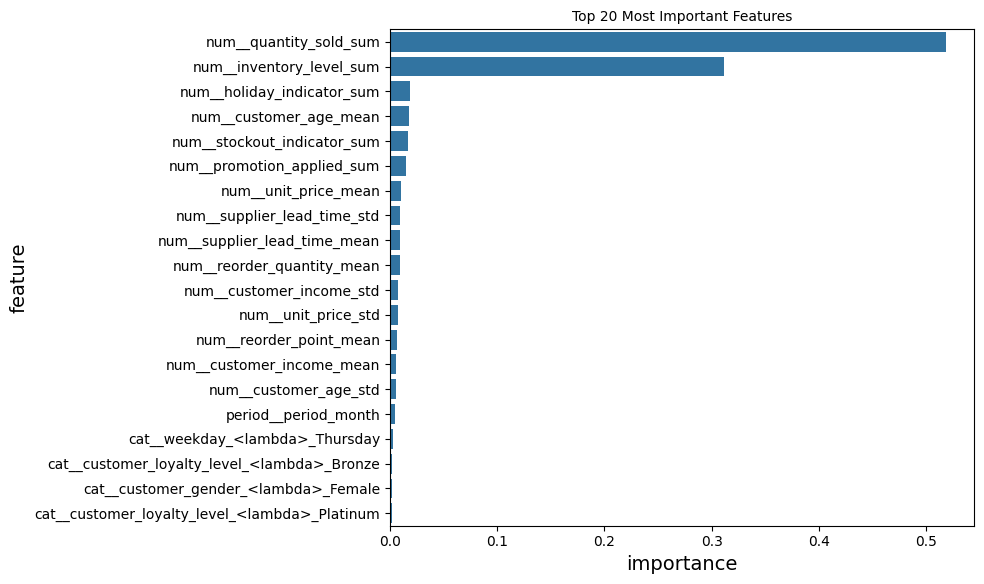

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


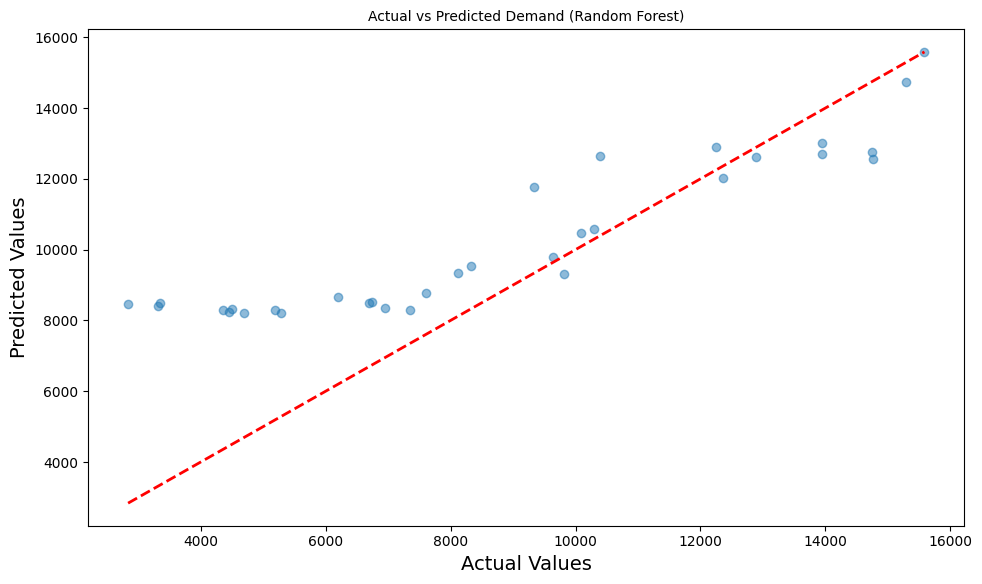

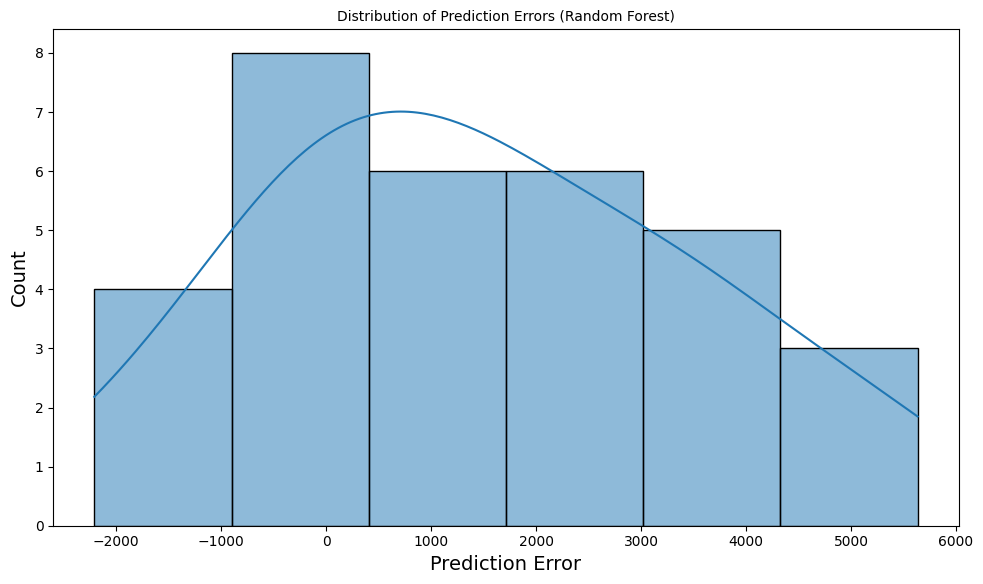

Model saved to best_model.pkl

Model Performance:
Train RMSE: 338.54
Test RMSE: 2513.04
95% Confidence Interval for Test RMSE: (1801.5141979470577, 3063.537133049014)

Top 10 Most Important Features:
                         feature  importance
0         num__quantity_sold_sum    0.518744
4       num__inventory_level_sum    0.311221
14    num__holiday_indicator_sum    0.018757
9         num__customer_age_mean    0.017392
15   num__stockout_indicator_sum    0.016437
13    num__promotion_applied_sum    0.014581
1           num__unit_price_mean    0.010023
8    num__supplier_lead_time_std    0.009755
7   num__supplier_lead_time_mean    0.009502
6     num__reorder_quantity_mean    0.008879


In [225]:
results = run_full_modeling_pipeline(df)
# 
# # Access results
print("\nModel Performance:")
print(f"Train RMSE: {results['analysis']['train_rmse']:.2f}")
print(f"Test RMSE: {results['analysis']['test_rmse']:.2f}")
print(f"95% Confidence Interval for Test RMSE: {results['analysis']['rmse_confidence_interval']}")
# 
print("\nTop 10 Most Important Features:")
print(results['analysis']['feature_importance'].head(10))

### Context
This analysis focuses on understanding and modeling product demand at Walmart. The dataset contains one year of customer transactions, including product attributes, pricing, inventory details, and customer demographics. The aim is to develop a predictive model for actual product demand. The initial hypothesis states that price and customer loyalty level are likely to be significant drivers of demand.

### Data
The data is stored in a CSV file named “walmart.csv” and was obtained from Kaggle. It captures transactions over a single year, which limits the availability of longer seasonal trends.

### Modeling Approach
Three methodologies were tested: linear regression, ARIMA, and Random Forest. Although the target variable (actual demand) is time-based, each model was adapted for time series cross-validation to properly account for temporal dependencies.

### Data Aggregation
Transaction-level data was consolidated to create a product-category-period dataset. Key features in this aggregated dataset include total quantity sold, average unit price, inventory statistics, and other computed or summary metrics.

### Data Visualization
Initial exploration employed histograms and time-series plots to understand distribution patterns and sales trends over the months. These visualizations provided a clearer picture of fluctuations in demand and helped guide feature engineering.

### Feature Engineering
Additional features were introduced, such as lag variables, to capture carry-over effects from previous periods. These features aimed to improve time-series forecasting by reflecting historical trends and potential momentum.

### Model Evaluation
The models’ performance was assessed using root mean squared error (RMSE). A significant disparity emerged between the train (338.54) and test (2513.04) RMSE, indicating that the best-performing model was overfit. The 95% confidence interval for the test RMSE ranged from 1801.51 to 3063.54, suggesting high variability in the out-of-sample predictions. The actual versus predicted plots further revealed that lower-demand values tended to be overestimated.

### Results
Model results showed that quantity sold and inventory level were the most influential features, with importance scores of 51.87% and 31.12% respectively. This contrasts with the initial hypothesis, which expected price and customer loyalty to predominate. The new insight points toward opportunities to optimize inventory management and address quantity fluctuations as key levers for improving demand forecasts.

### Threats to Validity
The single year of monthly data restricts the time horizon for modeling. Any seasonal patterns or broader economic shifts may not be fully captured, making extrapolation to future periods less reliable.

### Lessons Learned and Next Steps
Areas for improvement include focusing on lower-demand scenarios, where predictions exhibited higher errors, and enlarging the time horizon of the data to better capture varied demand patterns. It may also be helpful to revisit the assumption that price and customer loyalty significantly influence demand; in some cases, additional data or alternate modeling techniques could highlight these features’ impact more clearly.